In [54]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
image_size = 28 * 28  # Correct value for FashionMNIST
latent_size = 64
hidden_size = 256
num_epochs = 50
batch_size = 64
sample_dir = 'samples'

# Create a directory if not exists
import os
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# FashionMNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

# Device setting
D = D.to(device)
G = G.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

# Training
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        #print("Shape of images before reshaping:", images.shape)

        images = images.reshape(images.size(0), -1).to(device)


        # Add print statement to check the shape of the input tensor
        #print("Shape of input tensor to discriminator:", images.shape)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        # Real images
        outputs = D(images)
        d_loss_real = criterion(outputs, torch.ones_like(outputs))
        real_score = outputs

        # Fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, torch.zeros_like(outputs))
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch+1, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))


    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        torchvision.utils.save_image(images, os.path.join(sample_dir, 'real_images.png'), nrow=8, normalize=True)

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    torchvision.utils.save_image(fake_images, os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)), nrow=8, normalize=True)


Epoch [1/50], Step [200/938], d_loss: 0.0560, g_loss: 4.7043, D(x): 0.98, D(G(z)): 0.03
Epoch [1/50], Step [400/938], d_loss: 0.1857, g_loss: 3.4547, D(x): 0.95, D(G(z)): 0.11
Epoch [1/50], Step [600/938], d_loss: 0.0765, g_loss: 5.2017, D(x): 0.97, D(G(z)): 0.03
Epoch [1/50], Step [800/938], d_loss: 0.0755, g_loss: 4.7434, D(x): 0.98, D(G(z)): 0.02
Epoch [2/50], Step [200/938], d_loss: 0.0891, g_loss: 4.6081, D(x): 0.98, D(G(z)): 0.06
Epoch [2/50], Step [400/938], d_loss: 0.1278, g_loss: 6.1860, D(x): 0.98, D(G(z)): 0.03
Epoch [2/50], Step [600/938], d_loss: 0.0668, g_loss: 4.8998, D(x): 0.96, D(G(z)): 0.02
Epoch [2/50], Step [800/938], d_loss: 0.1608, g_loss: 5.4840, D(x): 0.96, D(G(z)): 0.06
Epoch [3/50], Step [200/938], d_loss: 0.0799, g_loss: 5.0323, D(x): 0.99, D(G(z)): 0.06
Epoch [3/50], Step [400/938], d_loss: 0.3859, g_loss: 4.2752, D(x): 0.90, D(G(z)): 0.09
Epoch [3/50], Step [600/938], d_loss: 0.0586, g_loss: 5.2783, D(x): 0.99, D(G(z)): 0.03
Epoch [3/50], Step [800/938], d_

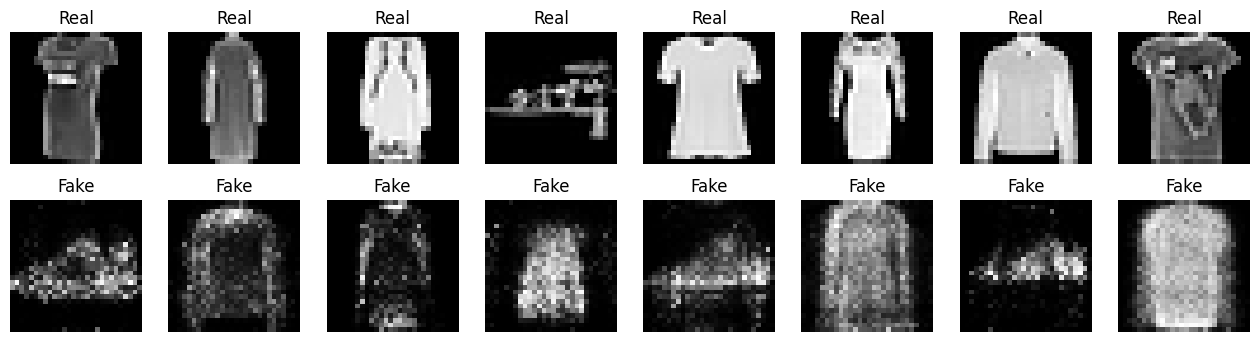

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some fake images
z = torch.randn(8, latent_size).to(device)
fake_images = G(z)
fake_images = fake_images.view(-1, 1, 28, 28).cpu().detach().numpy()

# Get some real images
real_images, _ = next(iter(train_loader))
real_images = real_images[:8]

# Plot real and fake images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(np.squeeze(real_images[i]), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Real')

    axes[1, i].imshow(np.squeeze(fake_images[i]), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Fake')

plt.show()


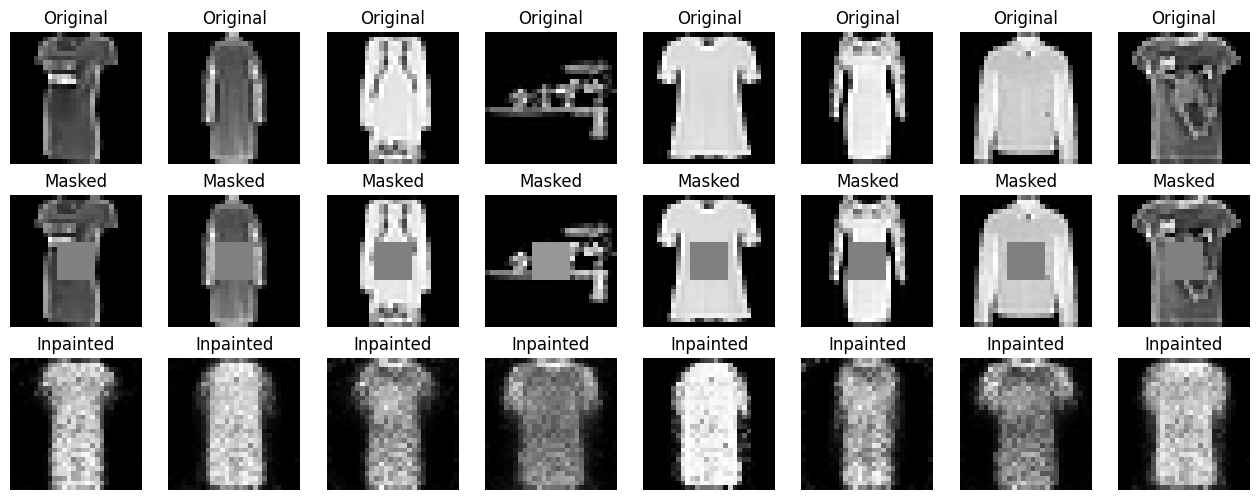

In [56]:
# Generate a masked version of the real images
masked_images = real_images.clone().to(device)  # Move masked images to the same device as the generator
mask = torch.ones_like(masked_images)  # Create a binary mask (all ones for simplicity)
masked_images[:, :, 10:18, 10:18] = 0  # Apply the mask to the images

# Feed the masked images into the generator to generate the missing parts
inpainted_images = G(masked_images.view(-1, latent_size)).view(-1, 1, 28, 28).cpu()

# Plot the original image, masked image, and inpainted image
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for i in range(8):
    axes[0, i].imshow(np.squeeze(real_images[i]), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(np.squeeze(masked_images[i].cpu().detach().numpy()), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Masked')

    axes[2, i].imshow(np.squeeze(inpainted_images[i].detach().numpy()), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title('Inpainted')

plt.show()


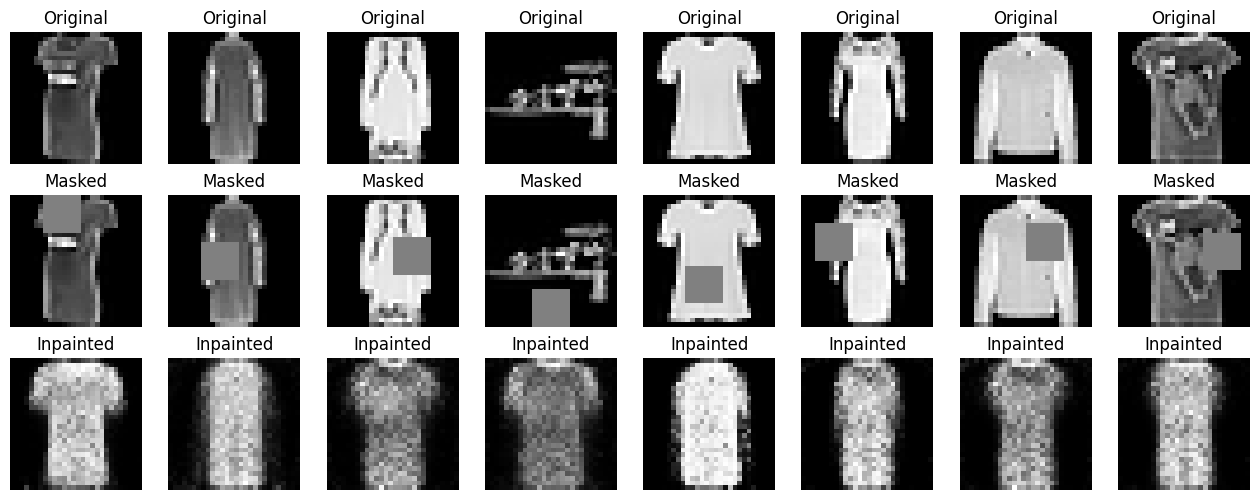

In [57]:
import random

# Define the size of the block mask
block_size = 8  # Change this value to adjust the size of the block mask

# Move the real images to the appropriate device
real_images = real_images.to(device)

# Generate random positions for the block mask for each image in the batch
positions = [(random.randint(0, 28 - block_size), random.randint(0, 28 - block_size)) for _ in range(real_images.shape[0])]

# Create a mask tensor for the block mask and move it to the same device as the images
mask = torch.ones_like(real_images).to(device)  # Initialize mask tensor with ones

# Apply the block mask to the mask tensor
for i, (start_row, start_col) in enumerate(positions):
    end_row = start_row + block_size
    end_col = start_col + block_size
    mask[i, :, start_row:end_row, start_col:end_col] = 0.0

# Apply the mask to the images
masked_images = real_images * mask

# Feed the masked images into the generator to generate the missing parts
inpainted_images = G(masked_images.view(-1, latent_size)).view(-1, 1, 28, 28).cpu()

# Plot the original image, masked image, and inpainted image
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for i in range(8):
    axes[0, i].imshow(np.squeeze(real_images[i].cpu().detach().numpy()), cmap='gray')  # Move to CPU for plotting
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(np.squeeze(masked_images[i].cpu().detach().numpy()), cmap='gray')  # Move to CPU for plotting
    axes[1, i].axis('off')
    axes[1, i].set_title('Masked')

    axes[2, i].imshow(np.squeeze(inpainted_images[i].detach().numpy()), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title('Inpainted')

plt.show()
